In [1]:
from PyPESTO.FRP import create_FRP2_v4
from PyPESTO.FRP.petab_ import plot_measurements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


In [2]:
# sbml_model_filepath = '/SBML/PyPESTO/FRP/sbml_model.xml'
amici_model, sbml_model_filepath = create_FRP2_v4.load_amici_from_sbml()

Creating SBML model (FRP2 v4)
Creating species.
Generating parameters.
Num Termination Reactions: 10
Creating reactions
Importing AMICI model from SBML


In [199]:
nx_pts = 20
ny_pts = 20
nz_pts = 20

# x1_log_range = [-1, 6]
# x2_log_range = [-8, 6]
# x3_log_range = [-8, 8]

x1_log_range = [-4, 8]
x2_log_range = [-4, 8]
x3_log_range = [-8, 4]

x1_vals = np.logspace(x1_log_range[0], x1_log_range[1], nx_pts, base=10)
x2_vals = np.logspace(x2_log_range[0], x2_log_range[1], ny_pts, base=10)
x3_vals = np.logspace(x3_log_range[0], x3_log_range[1], nz_pts, base=10)

def set_amici_kparams(model, kp, kt, kd):
    
    create_FRP2_v4.kpAA_true = kp
    create_FRP2_v4.kt_true = kt
    create_FRP2_v4.kd_true = kd
    
    create_FRP2_v4.rA_true = 10
    create_FRP2_v4.rB_true = 0.5
    create_FRP2_v4.rX_true = 1.0
    create_FRP2_v4.KAA_true = 0.5 #0.2 # 0.2
    create_FRP2_v4.KAB_true = 0.0 #0.3 # 0.3
    create_FRP2_v4.KBA_true = 0.0 #0.1 # 0.1
    create_FRP2_v4.KBB_true = 0.0 #0.5 # 0.5

    return model, (kp, kt, kd)
    
    
def set_amici_xparams(model, x1, x2, x3):
    
    # Set the parameters
    # x1 = kp
    # x2 = kt_kd_ratio = kt/kd
    # x3 = kp_kt_ratio = kp/kt
    
    # kp = x1
    # kt = kp / x3
    # kd = kt / x2
    
    kp = x1
    kt = x2
    kd = x3
    
    
    return set_amici_kparams(model, kp, kt, kd)

def calculate_var(mdf):
    
    mdf = mdf[mdf['time'] > 0]

    conditions = mdf['simulationConditionId'].unique()
    var = 0
    for c in conditions:
        c_mdf = mdf[mdf['simulationConditionId'] == c]
        var += np.var(c_mdf['xA']) + np.var(c_mdf['xB'])
    
    return var

def plot_var_matrix(var_matrix):
    
    fig, ax = plt.subplots(dpi=150)
    im = ax.imshow(var_matrix, origin='lower')
    # set a colorbar
    cbar = plt.colorbar(im)
    
    # fig.colorbar(im, cax=ax)

    # Define tick positions based on the range of values
    x1_tick_vals = np.array([10**i for i in range(min(x1_log_range), max(x1_log_range)+1, 2)]) 
    x2_tick_vals = np.array([10**i for i in range(min(x2_log_range), max(x2_log_range)+1, 2)])
    
    x1_tick_positions = np.interp(np.log10(x1_tick_vals), np.linspace(min(x1_log_range), max(x1_log_range), nx_pts), np.arange(nx_pts))
    x2_tick_positions = np.interp(np.log10(x2_tick_vals), np.linspace(min(x2_log_range), max(x2_log_range), ny_pts), np.arange(ny_pts))
    
    ax.set_xticks(x1_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in x1_tick_vals], rotation=45)
    ax.set_yticks(x2_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in x2_tick_vals])
    
    return ax

In [201]:
# Add each value to a dataframe storing x1, x2, and x3 values
import pandas as pd
var_df = pd.DataFrame(columns=['kp', 'kt', 'kd', 'var'])

from tqdm import tqdm
for i, x1 in tqdm(enumerate(x1_vals)):
    for j, x2 in enumerate(x2_vals):
        for k, x3 in enumerate(x3_vals):
        
            amici_model, (kp, kt, kd) = set_amici_xparams(amici_model, x1, x2, x3)
            cdf, mdf = create_FRP2_v4.generate_FRP_data(amici_model)
            var = calculate_var(mdf)
            # var = 0

            new_row = pd.DataFrame({'kp': [kp], 'kt': [kt], 'kd': [kd], 'var': [var]})
            var_df = pd.concat([var_df, new_row], ignore_index=True)    


0it [00:00, ?it/s]/tmp/ipykernel_96689/2060171829.py:16: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

2024-11-12 13:36:53.560 - amici.swig_wrappers - DEBUG - [CVODES:CVode:WARNING] AMICI ERROR: in module CVODES in function CVode : Internal t = 1877.94 and h = 1.08818e-13 are such that t + h = t on the next step. The solver will continue anyway. 
2024-11-12 13:36:53.561 - amici.swig_wrappers - DEBUG - [CVODES:CVode:WARNING] AMICI ERROR: in module CVODES in function CVode : Internal t = 1877.94 and h = 1.08818e-13 are such that t + h = t on the next step. The solver will continue anyway. 
2024-11-12 13:36:53.561 - amici.swig_wrappers - DEBUG - [CVODES:CVode:WARNING] AMICI ERROR: in module CVODES in function CVode : Internal t = 1877.94 and h

In [132]:

# var_df = pd.read_csv('/SBML/FRP_variance_data.csv', index_col=0)
print(var_df)
var_df.isnull().sum()

                kp            kt            kd           var
0     1.000000e-04  1.000000e-04  1.000000e-08  1.085960e-15
1     1.000000e-04  1.000000e-04  4.281332e-08  1.990488e-14
2     1.000000e-04  1.000000e-04  1.832981e-07  3.648042e-13
3     1.000000e-04  1.000000e-04  7.847600e-07  6.682955e-12
4     1.000000e-04  1.000000e-04  3.359818e-06  1.221966e-10
...            ...           ...           ...           ...
7995  1.000000e+08  1.000000e+08  2.976351e+01           NaN
7996  1.000000e+08  1.000000e+08  1.274275e+02  0.000000e+00
7997  1.000000e+08  1.000000e+08  5.455595e+02           NaN
7998  1.000000e+08  1.000000e+08  2.335721e+03  0.000000e+00
7999  1.000000e+08  1.000000e+08  1.000000e+04  1.301169e-09

[8000 rows x 4 columns]


kp       0
kt       0
kd       0
var    205
dtype: int64

In [142]:
import plotly.express as px

# Create a 3D scatter plot with log axes
# Keep a copy of the full dataset to extract axis limits
full_data_df = var_df.copy()

# Replace entries where var_df['var] > 1e10 with np.nan
var_df['var'] = var_df['var'].apply(lambda x: np.nan if x > 1e10 else x)

# Define variable names
x_name = 'kd'
y_name = 'kp'
z_name = 'kt'

# Filter the data based on variance threshold
# 
plot_df = var_df.copy()
plot_df = plot_df[plot_df['var'] > 0.75]

# Calculate axis limits from the full dataset
x_min, x_max = full_data_df[x_name].min(), full_data_df[x_name].max()
y_min, y_max = full_data_df[y_name].min(), full_data_df[y_name].max()
z_min, z_max = full_data_df[z_name].min(), full_data_df[z_name].max()

# Create the 3D scatter plot
fig = px.scatter_3d(plot_df, 
                    x=x_name, y=y_name, z=z_name, 
                    color='var', 
                    title='3D Scatter Plot with Logarithmic Axes')

# Set axes to log scale and apply fixed limits
fig.update_layout(scene=dict(
    xaxis=dict(type='log', title=x_name, range=[np.log10(x_min), np.log10(x_max)]),
    yaxis=dict(type='log', title=y_name, range=[np.log10(y_min), np.log10(y_max)]),
    zaxis=dict(type='log', title=z_name, range=[np.log10(z_min), np.log10(z_max)])
))

# Display the interactive plot
fig.show()


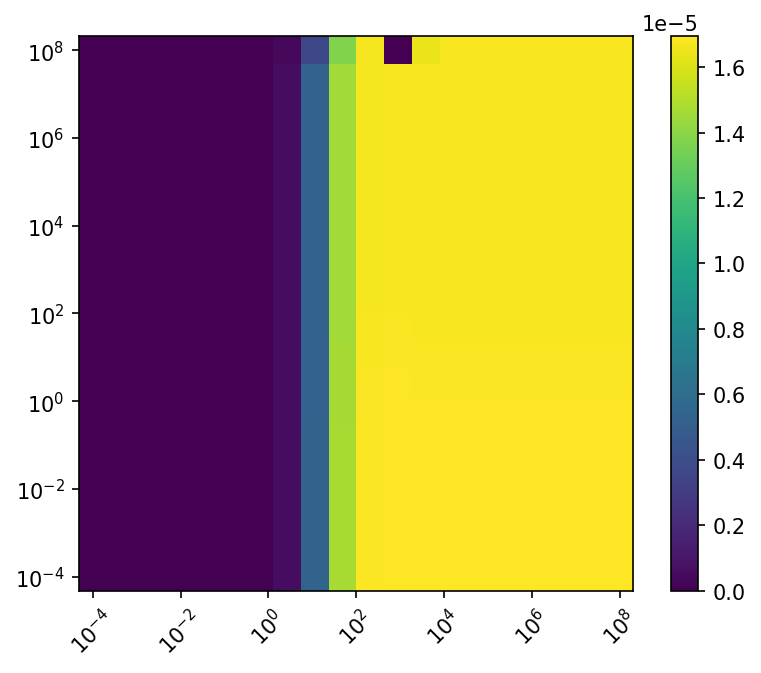

In [174]:
# Plot the var_df as a heatmap

# kp = x1
# kt = x2
# kd = x3

var_matrix = np.zeros((nx_pts, ny_pts))


for i, x2 in enumerate(x2_vals):
    for j, x3 in enumerate(x3_vals):
        var_matrix[i, j] = var_df[(var_df['kt'] == x2) & (var_df['kd'] == x3)]['var'].values[0]

ax = plot_var_matrix(var_matrix)

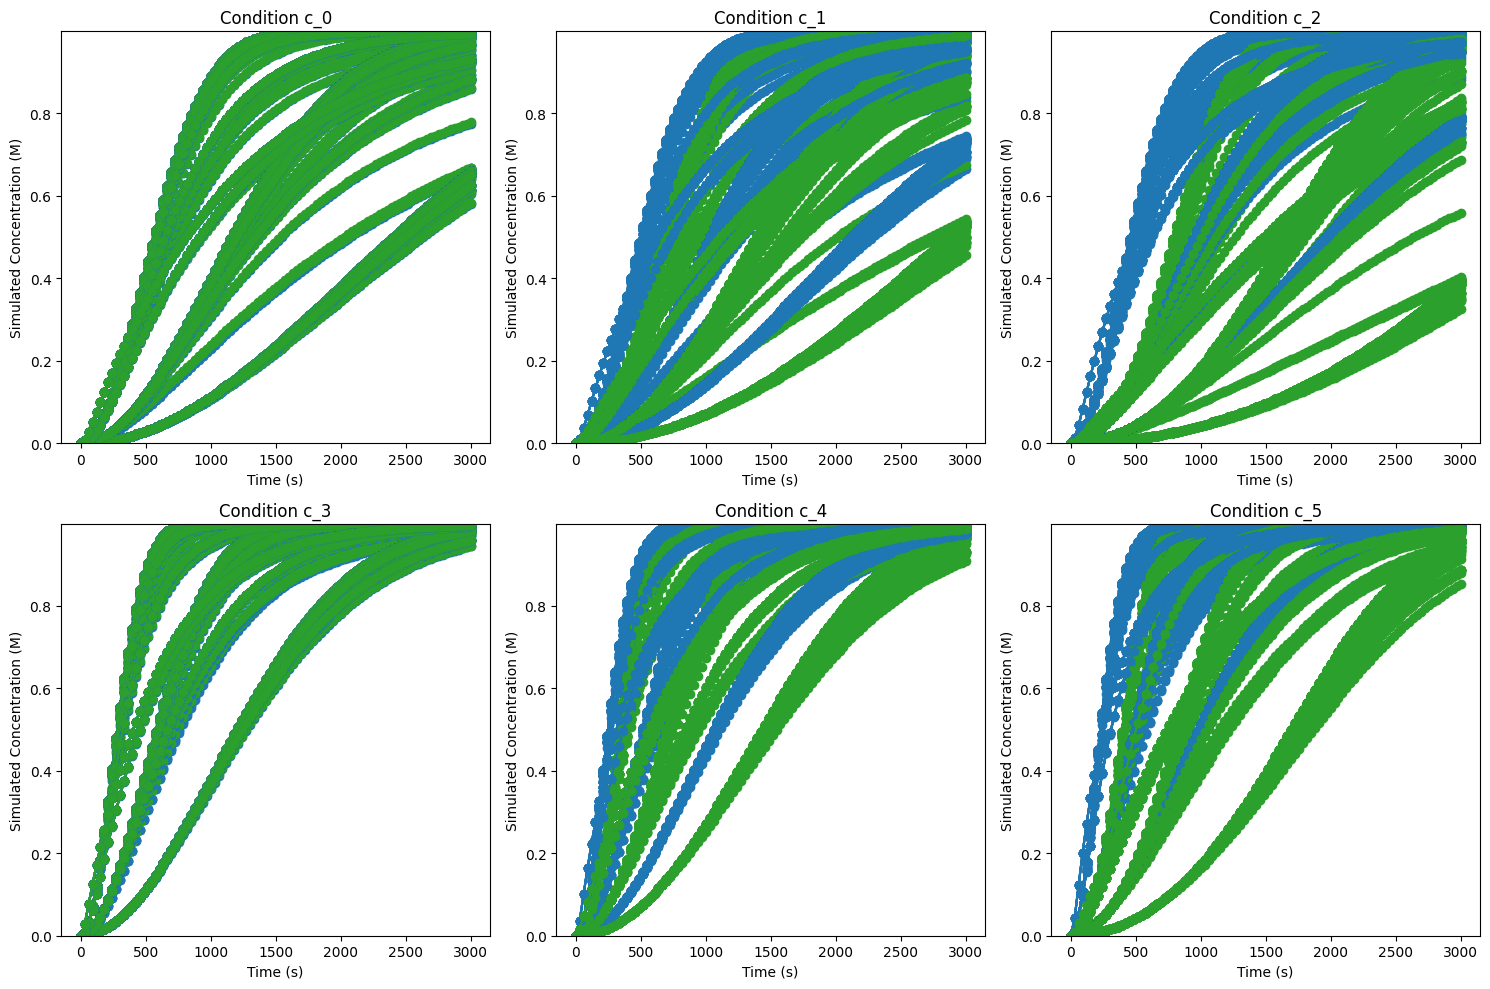

In [143]:
# Loop through plot_df, simulate the model, and plot the data
ax = None
count = 0
for i, row in plot_df.iterrows():
    amici_model, (kp, kt, kd) = set_amici_kparams(amici_model, row['kp'], row['kt'], row['kd'])
    cdf, mdf = create_FRP2_v4.generate_FRP_data(amici_model, real=True)
    # print(mdf)
    if ax is None:
        ax = plot_measurements(mdf)
    else:
        ax = plot_measurements(mdf, ax=ax)
    
    # if count == 1:
    #     break
    # count += 1

In [37]:
import plotly.express as px

# Create a 3D scatter plot with log axes
# df = var_df
plot_df = var_df.copy()

x_name = 'kd'
y_name = 'kp'
z_name = 'kt'
# x_name = 'kd'
# y_name = 'kp'
# z_name = 'kt'

# plot_df[x_name] = plot_df['kt'] / plot_df['kp']
# plot_df[y_name] = plot_df['kp'] / plot_df['kp']
# plot_df[z_name] = plot_df['kd'] / plot_df['kp']
# plot_df = plot_df[plot_df['var'] > 1.2]

# df = var_df[var_df['var'] > 0.15]
fig = px.scatter_3d(plot_df, 
                    x=x_name, y=y_name, z=z_name, 
                    color='var', 
                    title='3D Scatter Plot with Logarithmic Axes')

# Set axes to log scale
fig.update_layout(scene=dict(
    xaxis=dict(type='log', title=x_name),
    yaxis=dict(type='log', title=y_name),
    zaxis=dict(type='log', title=z_name)
))

# Display the interactive plot in the notebook
fig.show()


In [ ]:
plot_df[]

In [147]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

# Create a copy of the DataFrame and process it
plot_df = var_df.copy()
# x_name = 'kd_kt'
# y_name = 'kp_kt_ratio'
# z_name = 'kt'
x_name = 'kd'
y_name = 'kt'
z_name = 'kp'

# Compute new columns (on a raw scale)
# plot_df[x_name] = plot_df['kd']
# plot_df[y_name] = plot_df['kp']
# plot_df[x_name] = plot_df['kd'] / plot_df['kt']
# plot_df[y_name] = plot_df['kp'] / plot_df['kt']
full_data_df = plot_df.copy()
plot_df = plot_df[plot_df['var'] > 1.2]  # Filter data

# Take the logarithm of the data to transform it into log-space
log_X = np.log10(plot_df[[x_name, y_name]].values)  # Log of x and y
log_Z = np.log10(plot_df[z_name].values)  # Log of z

# Fit the linear regression model in log-space
model = LinearRegression()
model.fit(log_X, log_Z)

# Extract the coefficients from the model (in log-space)
a, b = model.coef_
d = model.intercept_

print(f"Log-space plane equation: log10(z) = {a:.3f} * log10(x) + {b:.3f} * log10(y) + {d:.3f}")

# Generate mesh grid in the original scale for plotting
x_range = np.logspace(np.log10(plot_df[x_name].min()), np.log10(plot_df[x_name].max()), 10, base=10)
y_range = np.logspace(np.log10(plot_df[y_name].min()), np.log10(plot_df[y_name].max()), 10, base=10)
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

# Predict the log(z) values for the mesh grid and convert them back to the original scale
z_mesh_log = a * np.log10(x_mesh) + b * np.log10(y_mesh) + d
z_mesh = 10**z_mesh_log  # Back-transform to the original scale

# Create the 3D scatter plot with Plotly
fig = px.scatter_3d(full_data_df, 
                    x=x_name, y=y_name, z=z_name, 
                    color='var', 
                    opacity=0.15,
                    title='3D Scatter Plot with Fitted Plane and Logarithmic Axes')

# Add the fitted plane to the plot
fig.add_trace(go.Surface(
    z=z_mesh, x=x_mesh, y=y_mesh, 
    colorscale='Viridis', opacity=0.5, 
    showscale=False))  # Plane surface

# Set the axes to log scale
fig.update_layout(scene=dict(
    xaxis=dict(type='log', title=x_name),
    yaxis=dict(type='log', title=y_name),
    zaxis=dict(type='log', title=z_name)
))

# Display the interactive plot
fig.show()


Log-space plane equation: log10(z) = -1.000 * log10(x) + -0.000 * log10(y) + -3.158


In [ ]:
var_df.to_csv('rA_10_.csv')

7889


0it [00:00, ?it/s]


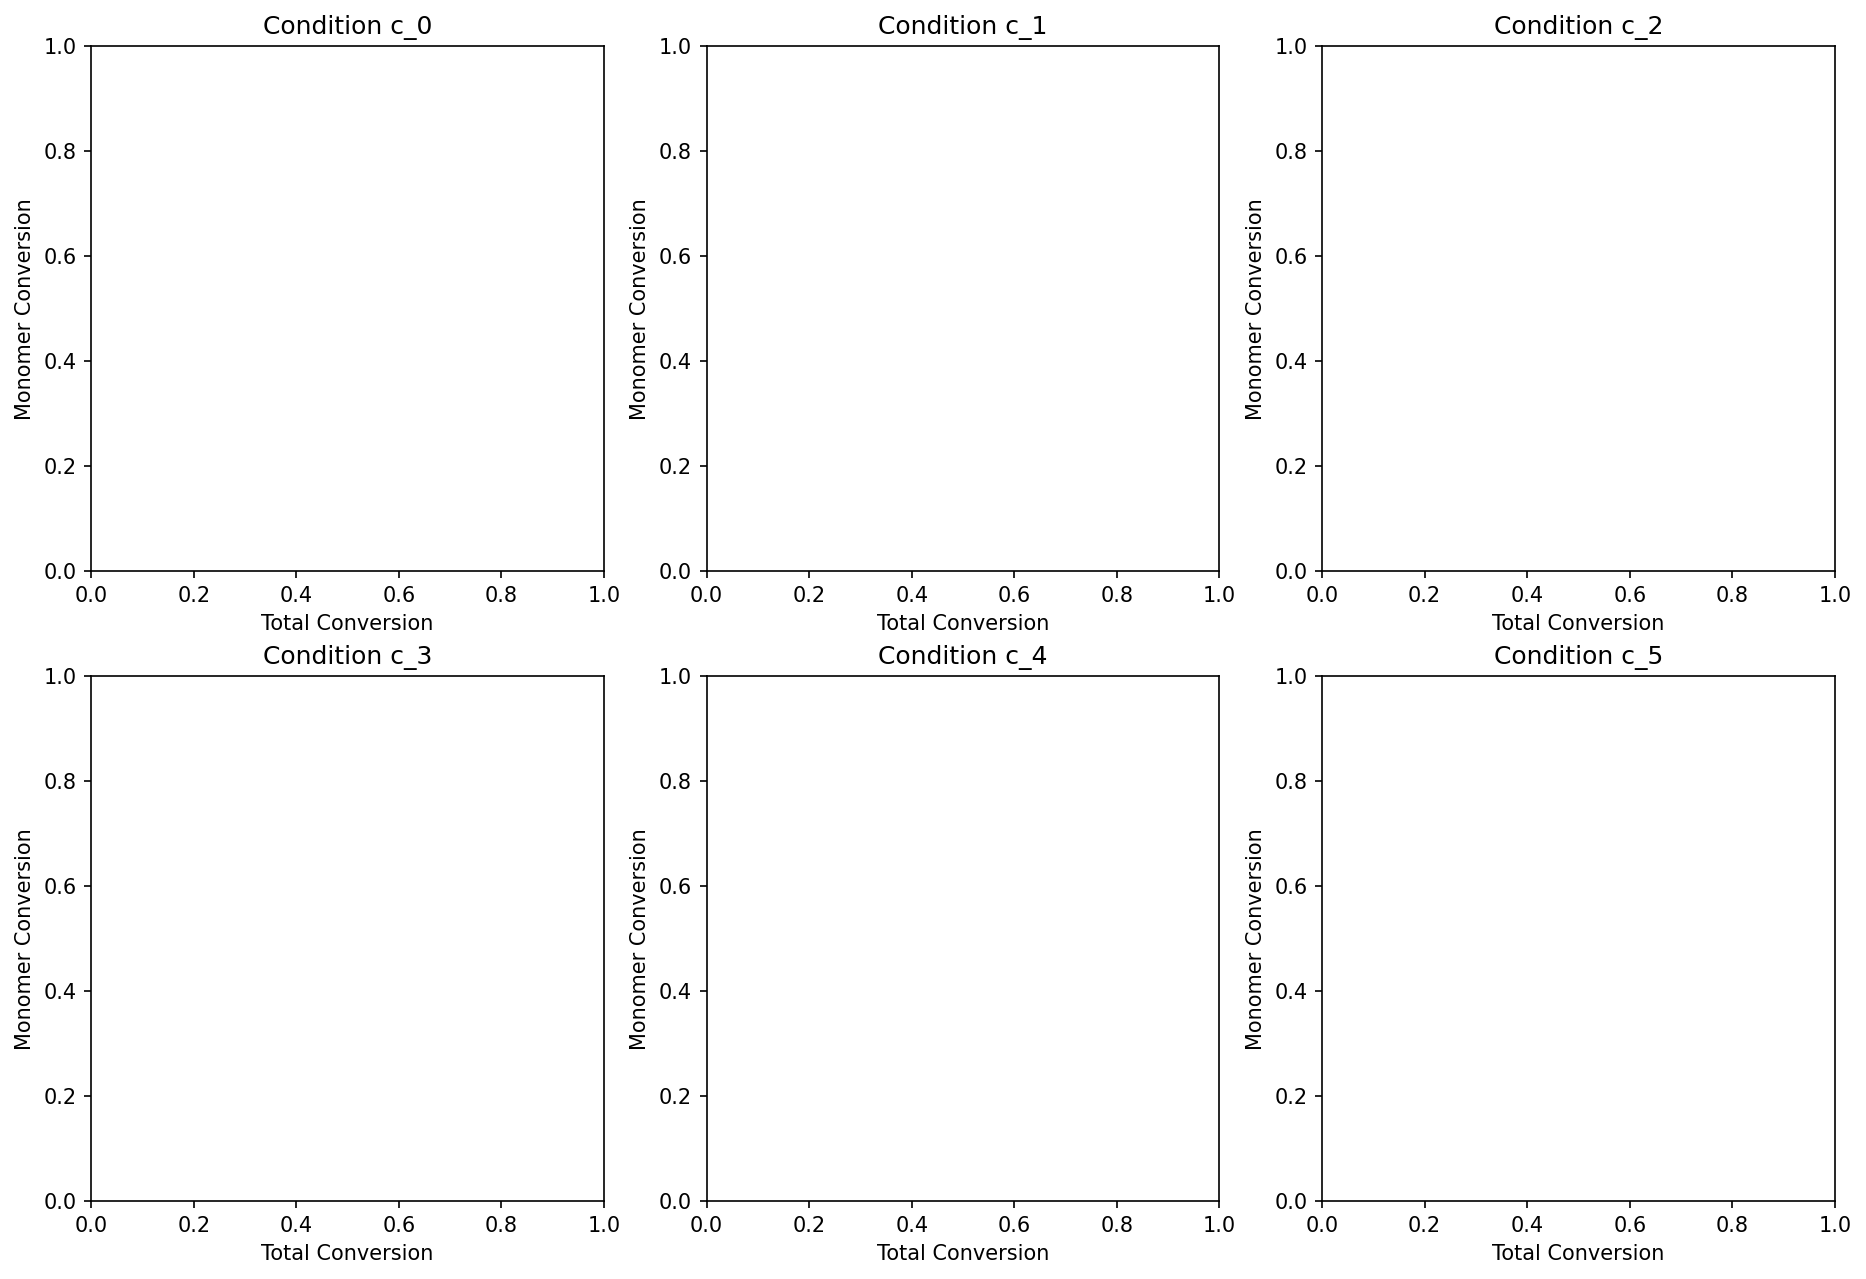

In [207]:
# Get points with high variance
from seaborn import axes_style
from tqdm import tqdm


var_cutoff = 0

hvar_df = var_df[var_df['var'] > var_cutoff]
hvar_df = hvar_df.reset_index(drop=True)

x_interp = np.linspace(0.1, 0.90, 81)

def plot_conversion_vs_time(mdf):
    fig, axs = plt.subplots(1, 2)
    for c in range(6):
        tmdf = mdf[mdf['simulationConditionId'] == f'c_{c}']
        axs[0].plot(tmdf['time'], tmdf['xA'])
        axs[1].plot(tmdf['time'], tmdf['xB'])
        axs[0].set_ylim(0, 1.1)
        axs[1].set_ylim(0, 1.1)
    plt.show()

print(len(hvar_df))
# Iterate through all rows in the high variance dataframe
# from tqdm import tqdm
# plt.figure(dpi=150)
fix, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=150)
axs = axs.flatten()
for i, row in tqdm(hvar_df.iterrows()):
    # print(ro/)
    amici_model, (kp, kt, kd) = set_amici_kparams(amici_model, row['kp'], row['kt'], row['kd'])
    cdf, mdf = create_FRP2_v4.generate_FRP_data(amici_model)
    mdf = mdf[mdf['time'] > 0]

    conditions = mdf['simulationConditionId'].unique()
    
    for j, c in enumerate(conditions):
        # c_mdf = mdf[mdf['simulationConditionId'] == c]
        
        # xA_interp = np.interp(x_interp, c_mdf['x'], c_mdf['xA'], left=np.nan, right=np.nan)
        # xB_interp = np.interp(x_interp, c_mdf['x'], c_mdf['xB'], left=np.nan, right=np.nan)
        # alpha = 0.15
        # axs[j].plot(x_interp, xA_interp, '-', color='tab:blue', alpha=alpha)
        # axs[j].plot(x_interp, xB_interp, '-', color='tab:orange', alpha=alpha)

        if i == 0:
            axs[j].set_title(f'Condition {c}')
            axs[j].set_ylim(0, 1.0)
            axs[j].set_xlim(0, 1.0)
            # axs[j].plot([0, 1], [0, 1], '--', color='black')
            axs[j].set_xlabel('Total Conversion')
            axs[j].set_ylabel('Monomer Conversion')
            # axs[j].legend(['A', 'B'], loc='upper left', frameon=False)
    break
# plt.xlim(0.05, 0.15)
# plt.ylim(0.25, 0.35)
plt.show()
    # axs = plot_measurements(mdf)
    
    # plot_conversion_vs_time(mdf)
    # break
    
    # axs[0].set_title(f'kp={kp}, kt={kt}, kd={kd}, var={row["var"]}')

In [203]:
var_df

kp            kt            kd           var
0     1.000000e-04  1.000000e-04  1.000000e-08  1.169603e-15
1     1.000000e-04  1.000000e-04  4.281332e-08  2.144059e-14
2     1.000000e-04  1.000000e-04  1.832981e-07  3.929644e-13
3     1.000000e-04  1.000000e-04  7.847600e-07  7.198932e-12
4     1.000000e-04  1.000000e-04  3.359818e-06  1.316341e-10
...            ...           ...           ...           ...
7995  1.000000e+08  1.000000e+08  2.976351e+01  2.369018e-03
7996  1.000000e+08  1.000000e+08  1.274275e+02           NaN
7997  1.000000e+08  1.000000e+08  5.455595e+02           NaN
7998  1.000000e+08  1.000000e+08  2.335721e+03           NaN
7999  1.000000e+08  1.000000e+08  1.000000e+04  2.703539e-03

[8000 rows x 4 columns]

280


0it [00:00, ?it/s]

kp 0.14384498882876628 kt 0.0001 kd 0.004832930238571752


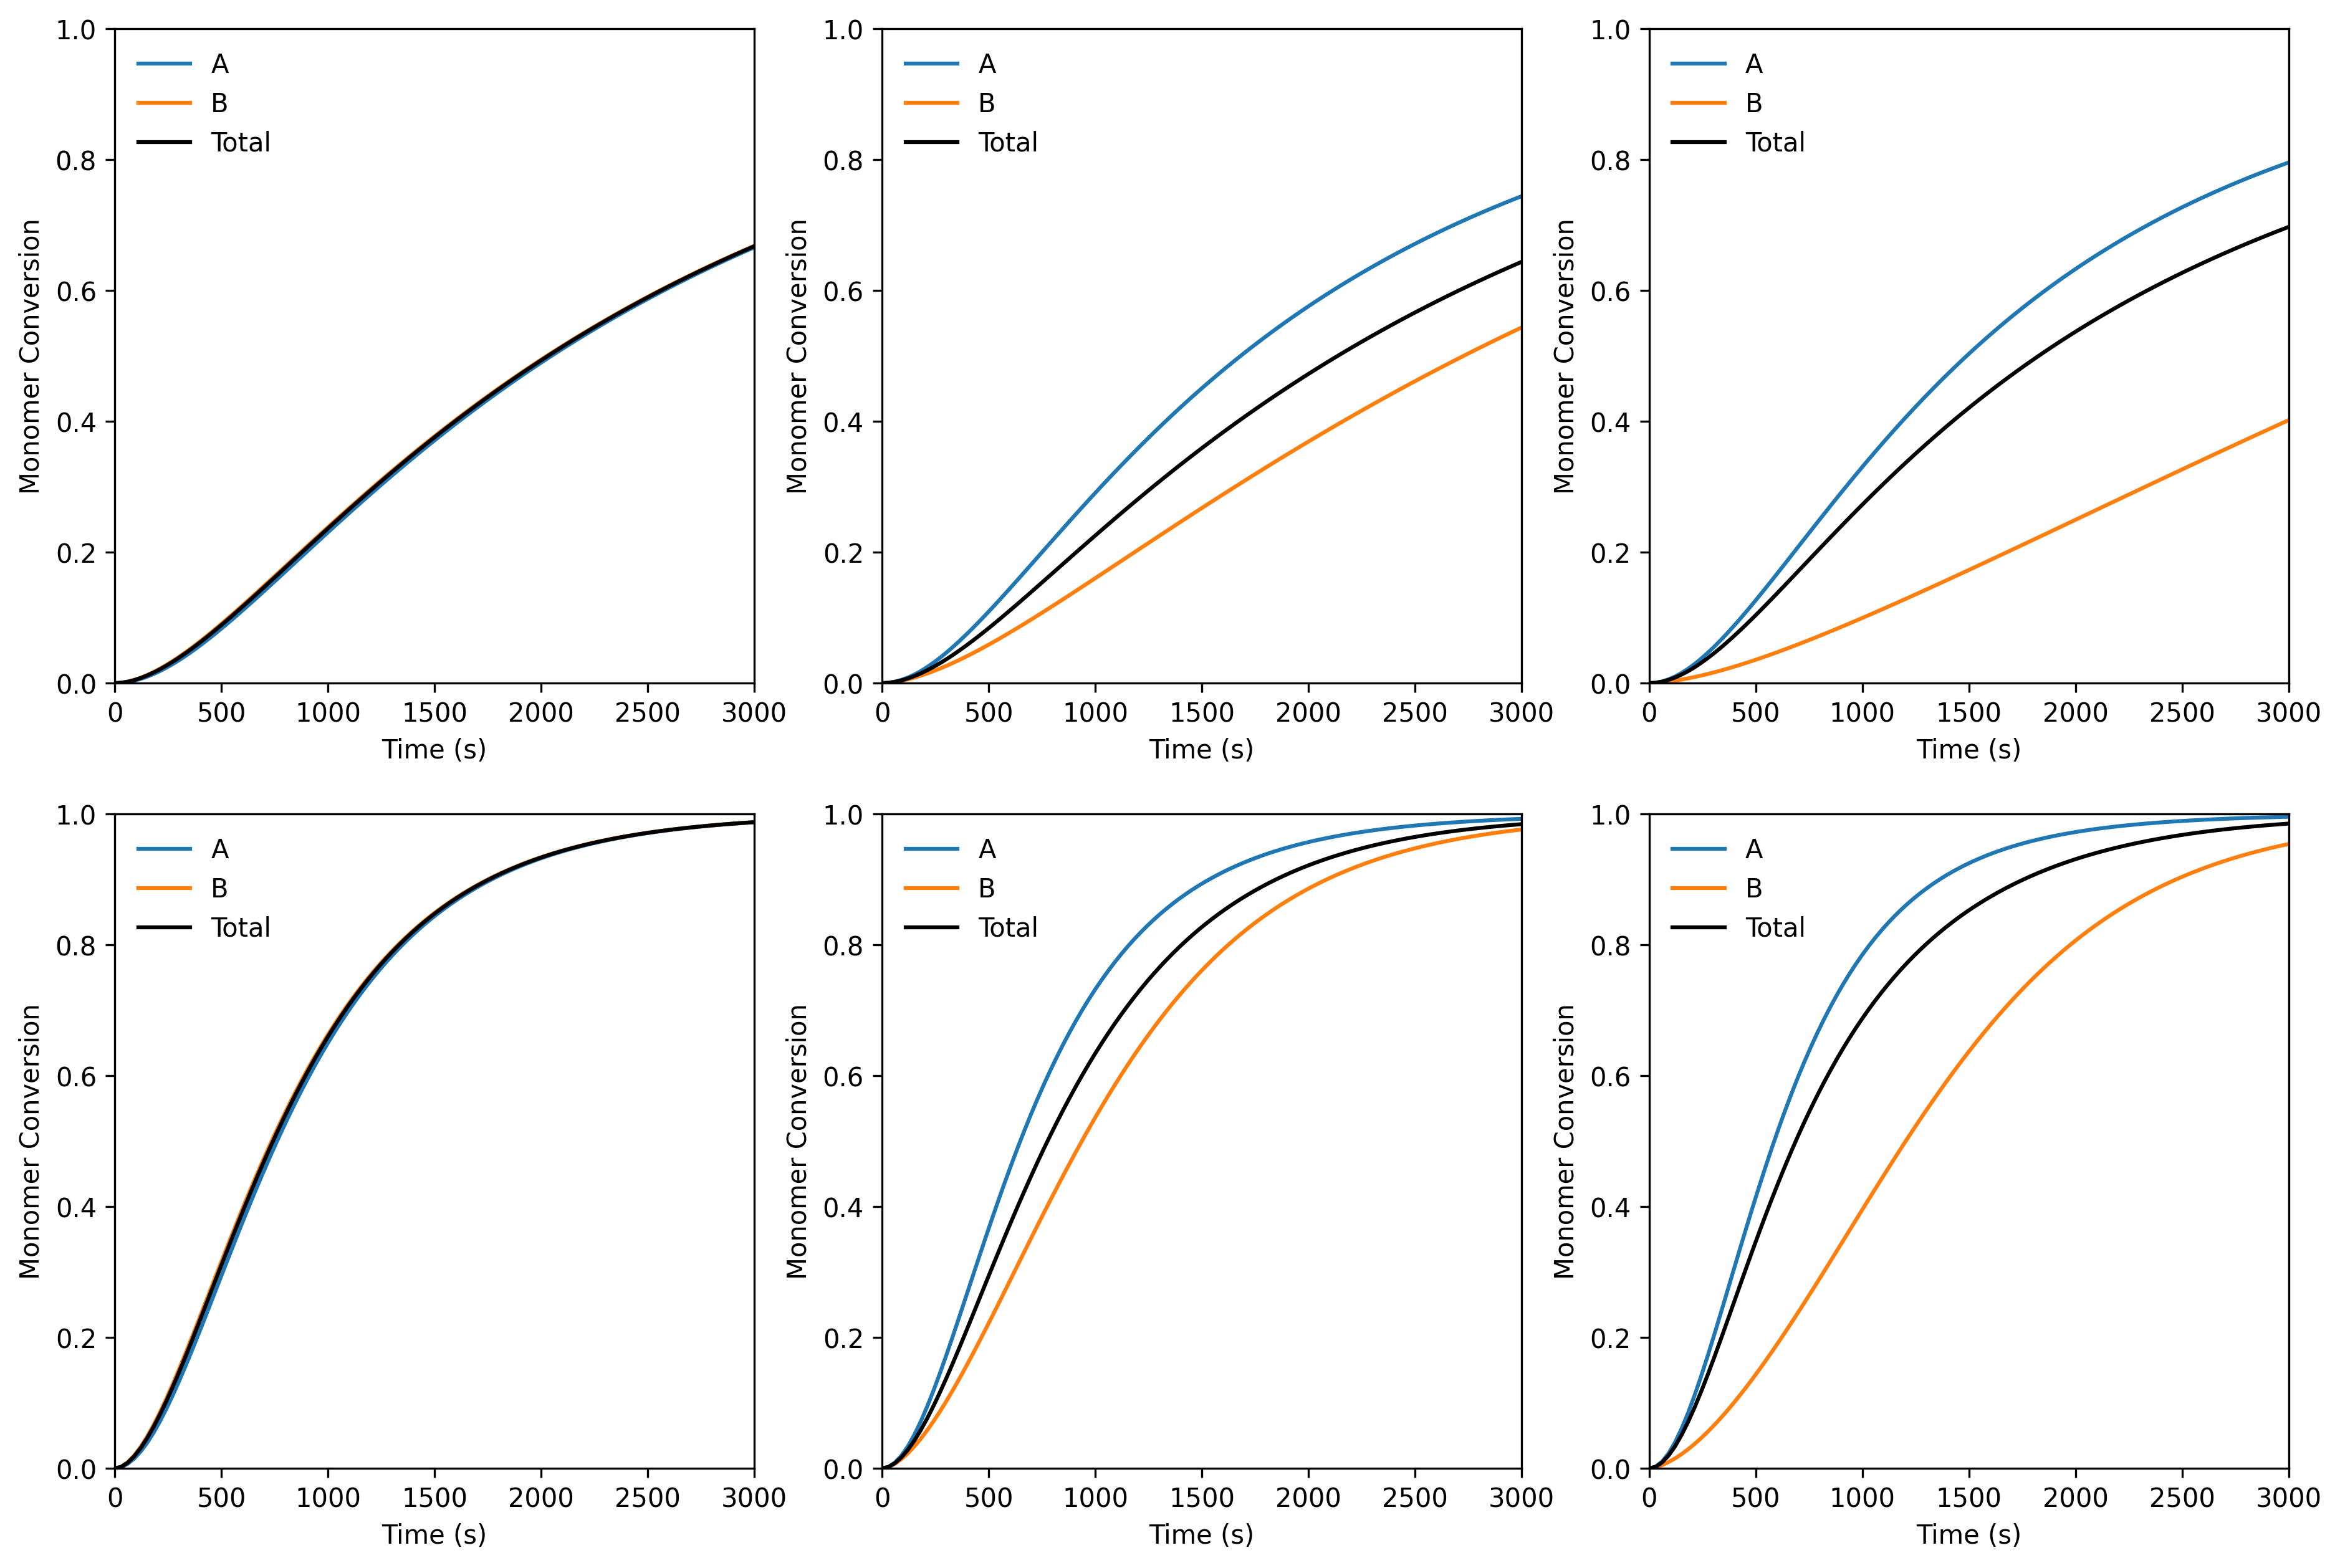

In [194]:
# Get points with high variance
from seaborn import axes_style
from tqdm import tqdm


lb_cutoff = 0.005
ub_cutoff = 0.01


hvar_df = var_df.copy()
hvar_df = hvar_df[hvar_df['var'] > 0.75]
# hvar_df = hvar_df[hvar_df['var'] < ub_cutoff]
# hvar_df = hvar_df[hvar_df['var'] > lb_cutoff]
hvar_df = hvar_df.reset_index(drop=True)

x_interp = np.linspace(0.1, 0.90, 81)
# x_interp = np.linspace(0.01, 0.99, 15)
# x_interp = np.linspace(0.00, 0.99, 110)

def plot_conversion_vs_time(mdf):
    fig, axs = plt.subplots(1, 2)
    for c in range(6):
        tmdf = mdf[mdf['simulationConditionId'] == f'c_{c}']
        axs[0].plot(tmdf['time'], tmdf['xA'])
        axs[1].plot(tmdf['time'], tmdf['xB'])
        axs[0].set_ylim(0, 1.1)
        axs[1].set_ylim(0, 1.1)
    plt.show()

print(len(hvar_df))
# Iterate through all rows in the high variance dataframe
# from tqdm import tqdm
# plt.figure(dpi=150)
fix, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
axs = axs.flatten()
for i, row in tqdm(hvar_df.iterrows()):
    # print(ro/)
    amici_model, (kp, kt, kd) = set_amici_kparams(amici_model, row['kp'], row['kt'], row['kd'])
    print('kp', kp, 'kt', kt, 'kd', kd)
    cdf, mdf = create_FRP2_v4.generate_FRP_data(amici_model)
    # mdf = mdf[mdf['time'] > 0]

    conditions = mdf['simulationConditionId'].unique()
    
    for j, c in enumerate(conditions):
        c_mdf = mdf[mdf['simulationConditionId'] == c]
        
        t_interp = np.interp(x_interp, c_mdf['x'], c_mdf['time'], left=np.nan, right=np.nan)
        xA_interp = np.interp(x_interp, c_mdf['x'], c_mdf['xA'], left=np.nan, right=np.nan)
        xB_interp = np.interp(x_interp, c_mdf['x'], c_mdf['xB'], left=np.nan, right=np.nan)
        alpha = 1
        # axs[j].plot(x_interp, xA_interp, '-', color='tab:blue', alpha=alpha)
        # axs[j].plot(x_interp, xB_interp, '-', color='tab:orange', alpha=alpha)
        axs[j].plot(c_mdf['time'], c_mdf['xA'], '-', color='tab:blue', alpha=alpha)
        axs[j].plot(c_mdf['time'], c_mdf['xB'], '-', color='tab:orange', alpha=alpha)
        axs[j].plot(c_mdf['time'], c_mdf['x'], '-', color='k', alpha=alpha)
        
        # axs[j].plot(t_interp, xA_interp, 'o-', color='tab:blue', alpha=alpha)
        # axs[j].plot(t_interp, xB_interp, 'o-', color='tab:orange', alpha=alpha)
        # axs[j].plot(c_mdf['time'], c_mdf['x'], '-', color='k', alpha=alpha)

        if i == 0:
            # axs[j].set_title(f'Condition {c}')
            axs[j].set_ylim(0, 1.0)
            # axs[j].set_xlim(0, 1.0)
            # axs[j].plot([0, 1], [0, 1], '-', color='black', alpha=0.25)
            # axs[j].set_xlabel('Total Conversion')
            axs[j].set_xlim([0, 3000])
            axs[j].set_xlabel('Time (s)')
            axs[j].set_ylabel('Monomer Conversion')
            # axs[j].legend(['B'], loc='upper left', frameon=False)
            axs[j].legend(['A', 'B'], loc='upper left', frameon=False)
            axs[j].legend(['A', 'B', 'Total'], loc='upper left', frameon=False)
    break
    # if int(i) > 0:
    #     break
    # break
# plt.xlim(0.05, 0.15)
# plt.ylim(0.25, 0.35)
plt.show()
    # axs = plot_measurements(mdf)
    
    # plot_conversion_vs_time(mdf)
    # break
    
    # axs[0].set_title(f'kp={kp}, kt={kt}, kd={kd}, var={row["var"]}')

In [ ]:
plt.

axs[j].plot(c_mdf['time'], c_mdf['xA'], '-', color='tab:blue', alpha=alpha)
axs[j].plot(c_mdf['time'], c_mdf['xB'], '-', color='tab:orange', alpha=alpha)
axs[j].plot(c_mdf['time'], c_mdf['x'], '-', color='k', alpha=alpha)

In [133]:
var_df.to_csv('FRP_variance_data.csv')

In [ ]:

x_interp

In [24]:
hvar_df

In [23]:
len(hvar_df)

In [69]:
import shap

var_df = var_df.dropna()
X = var_df[['kp', 'kt', 'kd']]
y = var_df['var']

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

explainer = shap.Explainer(model, X)

shap_values = explainer(X)


In [70]:
shap.summary_plot(shap_values, X)

In [74]:
shap.plots.beeswarm(shap_values)


In [43]:
corr = var_df[['kp', 'kt', 'kd', 'var']].corr()
print(corr)

In [28]:
ax = plot_var_matrix(var_matrix)
plt.show()
# ax.set_xlabel('$x_1$', fontsize=14)
# ax.set_ylabel('$x_2$', rotation=0, labelpad=20, fontsize=14)

In [ ]:
plt.figure(dpi=150)
plt.imshow(var_matrix, origin='lower')
# plt.ylabel('$k_d / k_p$', rotation=0, labelpad=20, fontsize=14)
# plt.xlabel('$k_t$ / $k_p$', fontsize=14)
plt.colorbar()

# Define tick positions based on the range of values
x_tick_vals = np.array([10**i for i in range(min(kt_kp_ratio_log_range), max(kt_kp_ratio_log_range)+1, 2)])  # Powers of ten from 10^-8 to 10^6
y_tick_vals = np.array([10**i for i in range(min(kd_kp_ratio_log_range), max(kd_kp_ratio_log_range)+1, 2)])  # Powers of ten from 10^-10 to 10^6

# Calculate approximate positions of these ticks relative to the data range
x_tick_positions = np.interp(np.log10(x_tick_vals), np.linspace(min(kt_kp_ratio_log_range), max(kt_kp_ratio_log_range), n_pts), np.arange(n_pts))
y_tick_positions = np.interp(np.log10(y_tick_vals), np.linspace(min(kd_kp_ratio_log_range), max(kd_kp_ratio_log_range), n_pts), np.arange(n_pts))

# Set the ticks and labels for powers of ten
# kp_pow = int(np.log10(create_FRP2_v4.kpAA_true))
kpAA_value = create_FRP2_v4.kpAA_true
kpAA_sci = "{:.1e}".format(kpAA_value)
kpAA_base, kpAA_exp = kpAA_sci.split("e")
kpAA_base = float(kpAA_base)
kpAA_exp = int(kpAA_exp)

# Use LaTeX formatting for the title
plt.title(f'Conversion Variance ($k_p$ = {kpAA_base} $\\times 10^{{{kpAA_exp}}}$)', fontsize=14)
# plt.title(f'Conversion Variance ($k_p$ = $10^{kp_pow}$) ')
plt.xticks(x_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in x_tick_vals], rotation=45)
plt.yticks(y_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in y_tick_vals])

# Show the plot
plt.show()

In [ ]:
def plot_conversion_vs_time(mdf):
    fig, axs = plt.subplots(1, 2)
    for c in range(6):
        tmdf = mdf[mdf['simulationConditionId'] == f'c_{c}']
        axs[0].plot(tmdf['time'], tmdf['xA'])
        axs[1].plot(tmdf['time'], tmdf['xB'])
        axs[0].set_ylim(0, 1.1)
        axs[1].set_ylim(0, 1.1)
    plt.show()
    
def plot_conversion_A_vs_B(mdf):
    fig, ax = plt.subplots(1, 1)
    for c in range(6):
        tmdf = mdf[mdf['simulationConditionId'] == f'c_{c}']
        ax.plot(tmdf['xB'], tmdf['xA'])
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
    plt.show()
    
n_pts = 20
kt_kp_ratio_log_range = [-8, 6]
kd_kp_ratio_log_range = [-10, 6]
kpAA_log_range = [1, 6]

# kt_range = kp_range * kt_kp_ratio_range = 1e-8 * 1 = 1e-8 or 1e6 * 1e6 = 1e12
# kt_range = 1e-8 to 1e12 (1e20 range)

# kd_range = kt_range / kt_kd_log_range = 1e-8 / (1e6) = 1e-14 or 1e12 / 1e-10 = 1e22
# kd_range = 1e-14 to 1e22 (1e36 range)

# kd_kp_ratio_range = kd_range / kp_range = 1e-14 / 1e6 = 1e-20 or 1e22 / 1e1 = 1e21
# kd_kp_ratio_range = 1e-20 to 1e21 (1e41 range)


kt_kp_ratios = 10**np.linspace(min(kt_kp_ratio_log_range), max(kt_kp_ratio_log_range), n_pts)
kd_kp_ratios = 10**np.linspace(min(kd_kp_ratio_log_range), max(kd_kp_ratio_log_range), n_pts)
var_matrix = np.zeros((len(kd_kp_ratios), len(kt_kp_ratios)))

create_FRP2_v4.kpAA_true = 1e1
create_FRP2_v4.rA_true = 10.0
create_FRP2_v4.rB_true = 0.1
create_FRP2_v4.rX_true = 1.0
create_FRP2_v4.KAA_true = 0
create_FRP2_v4.KAB_true = 0
create_FRP2_v4.KBA_true = 0
create_FRP2_v4.KBB_true = 0

for i, kd_kp_ratio in enumerate(kd_kp_ratios):
    for j, kt_kp_ratio in enumerate(kt_kp_ratios):
        create_FRP2_v4.kt_kp_ratio_true = kt_kp_ratio
        create_FRP2_v4.kd_kp_ratio_true = kd_kp_ratio
        
        kp = create_FRP2_v4.kpAA_true
        create_FRP2_v4.kt_true = create_FRP2_v4.kt_kp_ratio_true * kp
        create_FRP2_v4.kd_true = create_FRP2_v4.kd_kp_ratio_true * kp
        
        
        
        # create_FRP2_v4.kd_kt_true = kd_kt
        # create_FRP2_v4.kt_true = create_FRP2_v4.kt_kp_ratio_true * create_FRP2_v4.kpAA_true
        # create_FRP2_v4.kd_true = create_FRP2_v4.kd_kt_true / create_FRP2_v4.kt_true
    
        # print(kt_kp_ratio, kd_kt)
        
        cdf, mdf = create_FRP2_v4.generate_FRP_data(amici_model)
        mdf = mdf[mdf['time'] > 0]
        # print(mdf)
        var_xA = np.var(mdf['xA'])
        var_xB = np.var(mdf['xB'])
        var = var_xA + var_xB
        
        var_matrix[i, j] = var
        
        if var > 0.15:
            print(f'kpAA: {create_FRP2_v4.kpAA_true}')
            print(f'kt: {create_FRP2_v4.kt_true}')
            print(f'kd: {create_FRP2_v4.kd_true}')

In [ ]:
plt.figure(dpi=150)
plt.imshow(var_matrix, origin='lower')
plt.ylabel('$k_d / k_p$', rotation=0, labelpad=20, fontsize=14)
plt.xlabel('$k_t$ / $k_p$', fontsize=14)
plt.colorbar()

# Define tick positions based on the range of values
x_tick_vals = np.array([10**i for i in range(min(kt_kp_ratio_log_range), max(kt_kp_ratio_log_range)+1, 2)])  # Powers of ten from 10^-8 to 10^6
y_tick_vals = np.array([10**i for i in range(min(kd_kp_ratio_log_range), max(kd_kp_ratio_log_range)+1, 2)])  # Powers of ten from 10^-10 to 10^6

# Calculate approximate positions of these ticks relative to the data range
x_tick_positions = np.interp(np.log10(x_tick_vals), np.linspace(min(kt_kp_ratio_log_range), max(kt_kp_ratio_log_range), n_pts), np.arange(n_pts))
y_tick_positions = np.interp(np.log10(y_tick_vals), np.linspace(min(kd_kp_ratio_log_range), max(kd_kp_ratio_log_range), n_pts), np.arange(n_pts))

# Set the ticks and labels for powers of ten
# kp_pow = int(np.log10(create_FRP2_v4.kpAA_true))
kpAA_value = create_FRP2_v4.kpAA_true
kpAA_sci = "{:.1e}".format(kpAA_value)
kpAA_base, kpAA_exp = kpAA_sci.split("e")
kpAA_base = float(kpAA_base)
kpAA_exp = int(kpAA_exp)

# Use LaTeX formatting for the title
plt.title(f'Conversion Variance ($k_p$ = {kpAA_base} $\\times 10^{{{kpAA_exp}}}$)', fontsize=14)
# plt.title(f'Conversion Variance ($k_p$ = $10^{kp_pow}$) ')
plt.xticks(x_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in x_tick_vals], rotation=45)
plt.yticks(y_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in y_tick_vals])

# Show the plot
plt.show()

In [ ]:
plt.figure(dpi=150)
plt.imshow(var_matrix, origin='lower')
plt.ylabel('$k_d*k_t$', rotation=0, labelpad=20, fontsize=14)
plt.xlabel('$k_t$ / $k_p$', fontsize=14)
plt.colorbar()

# Define tick positions based on the range of values
x_tick_vals = np.array([10**i for i in range(min(kt_kp_ratio_log_range), max(kt_kp_ratio_log_range)+1, 2)])  # Powers of ten from 10^-8 to 10^6
y_tick_vals = np.array([10**i for i in range(min(kd_kt_log_range), max(kd_kt_log_range)+1, 2)])  # Powers of ten from 10^-10 to 10^6

# Calculate approximate positions of these ticks relative to the data range
x_tick_positions = np.interp(np.log10(x_tick_vals), np.linspace(min(kt_kp_ratio_log_range), max(kt_kp_ratio_log_range), n_pts), np.arange(n_pts))
y_tick_positions = np.interp(np.log10(y_tick_vals), np.linspace(min(kd_kt_log_range), max(kd_kt_log_range), n_pts), np.arange(n_pts))

# Set the ticks and labels for powers of ten
kp_pow = int(np.log10(create_FRP2_v4.kpAA_true))
plt.title(f'Conversion Variance ($k_p$ = $10^{kp_pow}$) ')
plt.xticks(x_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in x_tick_vals], rotation=45)
plt.yticks(y_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in y_tick_vals])

# Show the plot
plt.show()

In [ ]:
create_FRP2_v4.kpAA_true = 1e0
create_FRP2_v4.kt_kp_ratio_true = 1e-4
create_FRP2_v4.kd_kt_true = 1e-8
create_FRP2_v4.kt_true = create_FRP2_v4.kt_kp_ratio_true * create_FRP2_v4.kpAA_true
create_FRP2_v4.kd_true = create_FRP2_v4.kd_kt_true / create_FRP2_v4.kt_true
# print(kt_kp_ratio, kd_kt)

cdf, mdf = create_FRP2_v4.generate_FRP_data(amici_model)
mdf = mdf[mdf['time'] > 0]
plot_conversion_vs_time(mdf)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(var_matrix)
plt.ylabel('kd_kt')
plt.xlabel('kt_kp_ratio')
plt.colorbar()
plt.show()
plt.imshow(var_matrix > 0.15)
plt.ylabel('kd_kt')
plt.xlabel('kt_kp_ratio')
plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(var_matrix)
plt.ylabel('kd_kt')
plt.xlabel('kt_kp_ratio')
plt.colorbar()

# Define tick positions based on the range of values
x_tick_vals = np.array([10**i for i in range(-8, 7, 2)])  # Powers of ten from 10^-8 to 10^6
y_tick_vals = np.array([10**i for i in range(-10, 7, 2)])  # Powers of ten from 10^-10 to 10^6

# Calculate approximate positions of these ticks relative to the data range
x_tick_positions = np.interp(np.log10(x_tick_vals), np.linspace(-8, 6, n_pts), np.arange(n_pts))
y_tick_positions = np.interp(np.log10(y_tick_vals), np.linspace(-10, 6, n_pts), np.arange(n_pts))

# Set the ticks and labels for powers of ten
plt.xticks(x_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in x_tick_vals], rotation=45)
plt.yticks(y_tick_positions, [f'$10^{{{int(np.log10(val))}}}$' for val in y_tick_vals])

# Show the plot
plt.show()

# plt.show()
# plt.imshow(var_matrix > 0.10)
# plt.ylabel('kd_kt')
# plt.xlabel('kt_kp_ratio')
# plt.colorbar()

In [ ]:
create_FRP2_v4.kd_true = kd_true = 1e-6
create_FRP2_v4.kt_true = kt_true = 0*1e6

create_FRP2_v4.kpAA_true = kpAA_true = 1 + 0*1e6
create_FRP2_v4.rA_true = rA_true = 0.5
create_FRP2_v4.rB_true = rB_true = 18
create_FRP2_v4.rX_true = rX_true = 1.0
create_FRP2_v4.KBB_true = KBB_true = 0.5


create_FRP2_v4.kt_kp_ratio_true = kt_kp_ratio_true = kt_true / kpAA_true
create_FRP2_v4.kd_kp_true = kd_kp_true = kd_true * kpAA_true
# create_FRP2_v4.kp_kt_ratio_true = kp_kt_ratio_true = kpAA_true / kt_true
# create_FRP2_v4.kd_kt_true = kd_kt_true = kd_true * kt_true

yaml_filepath = create_FRP2_v4.write_petab_files(amici_model, sbml_model_filepath)
observables_df, conditions_df, measurements_df = create_FRP2_v4.define_FRP_measurements(amici_model)
fig, axs = plot_measurements(measurements_df, conversion=True)

In [ ]:
import logging

import numpy as np
import petab
import amici
import amici.plotting
import sys
import os
import importlib

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

# log diagnostics
logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

# import to petab
yaml_filepath = '/SBML/PyPESTO/FRP/FRP2_v4/FRP2_v4.yaml'
petab_problem = petab.Problem.from_yaml(
    yaml_filepath
)
# importer = pypesto.petab.PetabImporter(petab_problem, model_name=create_FRP_v1.MODEL_NAME)

importer = pypesto.petab.PetabImporter.from_yaml(
    yaml_filepath,
    model_name=create_FRP2_v4.MODEL_NAME,
)

# Works when it runs twice for some reason
try:
    problem = importer.create_problem(force_compile=True)
except:
    problem = importer.create_problem(force_compile=True)

In [ ]:
observables_df, conditions_df, measurements_df = create_FRP2_v4.define_FRP_measurements(amici_model)

plot_measurements(measurements_df)

In [ ]:
conv_df = measurements_df.copy()
conditions = measurements_df[SIMULATION_CONDITION_ID].unique()
observables = measurements_df[OBSERVABLE_ID].unique()
variance_dict = {}
for c in conditions:
    for o in observables:
        meas_data = conv_df.loc[(conv_df[SIMULATION_CONDITION_ID] == c) & (conv_df[OBSERVABLE_ID] == o), MEASUREMENT]
        max_conc = meas_data.max()
        conv_data = (max_conc - meas_data) / max_conc
        conv_df.loc[(conv_df[SIMULATION_CONDITION_ID] == c) & (conv_df[OBSERVABLE_ID] == o), MEASUREMENT] = conv_data
        
        # Compute the variance of the converted data
        variance_dict[(c, o)] = conv_data.var()

print(np.sum(list(variance_dict.values())))
variance_dict

In [ ]:
# x axis: kp_kt_ratio
# y axis: kd_kt

# Create a heatmap of some kind of measure of data "quality"
# Bad data:
# - data stays at initial value (too slow)
# - data instantly goes to zero (too fast)

# Create a grid of parameter values
kp_kt_ratio_values = np.logspace(-6, 6, 100, base=10)
kd_kt_values = np.logspace(-6, 6, 100, base=10)



# Run the simulations for these parameters
# Calculate the data quality metric for each set of parameters (sum of variances)
# Plot the heatmap

# kd, kp, kt

In [ ]:
kp_kt_ratio_values

In [ ]:
np.sum(list(variance_dict.values()))

In [ ]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), 
    n_chains=3,
)

In [ ]:
%%capture
n_samples = 100_000
result = sample.sample(
    problem,
    n_samples=n_samples,
    sampler=sampler,
    x0=np.array([
        np.log(1),
        np.log(1),
        np.log(1),
        # np.log(1/0.5),
        # np.log(1/18),
        # np.log(1/1),
        # np.log(0.5),
        # # 0,
        # # 0,
        # # 0,
        # # 2,
        # # np.log(1/rA_true),
        # # np.log(1/rB_true),
        # # np.log(1/rX_true),
        # # np.log(1/KBB_true),
        # np.log(1e5),
        # np.log(1/kp_kt_ratio_true),
        # np.log(1/kd_kt_true),
    ]),
    filename=None,
)
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

In [ ]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5),
    # par_indices=[0,1,2,3]
)

# ax[0][0].plot([0, n_samples], np.log([rA_true, rA_true]), "k--")
# ax[0][1].plot([0, n_samples], np.log([rB_true, rB_true]), "k--")
# ax[1][0].plot([0, n_samples], np.log([rX_true, rX_true]), "k--")
# ax[1][1].plot([0, n_samples], np.log([KBB_true, KBB_true]), "k--")

ax[0][0].plot([0, n_samples], np.log([rA_true, rA_true]), "k--")
ax[0][1].plot([0, n_samples], np.log([rB_true, rB_true]), "k--")
# ax[0][2].plot([0, n_samples], np.log([rX_true, rX_true]), "k--")
ax[1][0].plot([0, n_samples], np.log([KBB_true, KBB_true]), "k--")
# ax[1][1].plot([0, n_samples], np.log([kpAA_true, kpAA_true]), "k--")
# ax[1][2].plot([0, n_samples], np.log([kp_kt_ratio_true, kp_kt_ratio_true]), "k--")
# ax[2][0].plot([0, n_samples], np.log([kd_kt_true, kd_kt_true]), "k--")


In [ ]:
it_start = sample.geweke_test(result=result)
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5),
    par_indices=[0,1,2,3]
)
ax[0][0].plot([0, n_samples], np.log([rA_true, rA_true]), "k--")
ax[0][1].plot([0, n_samples], np.log([rB_true, rB_true]), "k--")
ax[1][0].plot([0, n_samples], np.log([rX_true, rX_true]), "k--")
ax[1][1].plot([0, n_samples], np.log([KBB_true, KBB_true]), "k--")
# ax[0][0].plot([it_start, n_samples], np.log([rA_true, rA_true]), "k--")
# ax[0][1].plot([it_start, n_samples], np.log([rB_true, rB_true]), "k--")
# ax[0][2].plot([it_start, n_samples], np.log([rX_true, rX_true]), "k--")
# ax[1][0].plot([it_start, n_samples], np.log([KBB_true, KBB_true]), "k--")
# ax[1][1].plot([it_start, n_samples], np.log([kpAA_true, kpAA_true]), "k--")
# ax[1][2].plot([it_start, n_samples], np.log([kp_kt_ratio_true, kp_kt_ratio_true]), "k--")
# ax[2][0].plot([it_start, n_samples], np.log([kd_kt_true, kd_kt_true]), "k--")

In [ ]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=True, full_trace=True, size=(10, 4),
    par_indices=[0,1,2,3]
)
# ax[0][0].plot([0, n_samples], np.log([rA_true, rA_true]), "k--")
# ax[0][1].plot([0, n_samples], np.log([rB_true, rB_true]), "k--")
# ax[0][2].plot([0, n_samples], np.log([rX_true, rX_true]), "k--")
# ax[1][0].plot([0, n_samples], np.log([kpAA_true, kpAA_true]), "k--")
# ax[1][1].plot([0, n_samples], np.log([kt_true, kt_true]), "k--")

In [ ]:
alpha = [99, 95, 90]
import matplotlib.pyplot as plt
ax = visualize.sampling_parameter_cis(result, alpha=alpha, size=(10, 5))
line1, = ax.plot([np.log(rA_true)], 0, 'o', color='tab:red')
line2, = ax.plot([np.log(rB_true)], 1, 'o', color='tab:red')
line3, = ax.plot([np.log(rX_true)], 2, 'o', color='tab:red')
line4, = ax.plot([np.log(KBB_true)], 3, 'o', color='tab:red')
line5, = ax.plot([np.log(kpAA_true)], 4, 'o', color='tab:red')
line6, = ax.plot([np.log(kp_kt_ratio_true)], 5, 'o', color='tab:red')
line7, = ax.plot([np.log(kd_kt_true)], 6, 'o', color='tab:red')
# line4, = ax.plot([np.log(kpAA_true)], 3, 'o', color='tab:red')
# line5, = ax.plot([np.log(kt_true)], 4, 'o', color='tab:red')

# ax.legend()
# Get existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()

unique_handles_labels = list(dict(zip(labels, handles)).items())
unique_labels, unique_handles = zip(*unique_handles_labels)

# Update the legend with unique handles and labels
ax.legend(unique_handles, unique_labels)
ax.set_yticks([0,1,2,3,4,5,6],['$r_{A}$', '$r_{B}$', '$r_{X}$', '$K_{BB}$', '$k_{pAA}$', '${k_{pAA}}{k_{t}}^{-1}$', '${k_{d}}{k_{t}}$'])
ax.set_xlabel('parameter value')
ax.set_ylabel('')
# ax.set_xlim(-5, 5)
plt.show()
# ax.vlines(np.log([k1_true, k2_true]), 0, 1, color="k", linestyle="--")

In [ ]:
np.exp(sample.calculate_ci_mcmc_sample(result, ci_level=0.6827))

In [ ]:
for i_chain in range(len(result.sample_result.betas)):
    ax = visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}"
    )
    
    y_max_00 = ax[0][0].get_ylim()[1]
    y_max_01 = ax[0][1].get_ylim()[1]
    y_max_02 = ax[0][2].get_ylim()[1]
    y_max_10 = ax[1][0].get_ylim()[1]
    y_max_11 = ax[1][1].get_ylim()[1]
    y_max_12 = ax[1][2].get_ylim()[1]
    y_max_20 = ax[2][0].get_ylim()[1]
    
    ax[0][0].vlines(np.log(rA_true),   0, y_max_00, color="tab:red", linestyle="--")
    ax[0][1].vlines(np.log(rB_true),   0, y_max_01, color="tab:red", linestyle="--")
    ax[0][2].vlines(np.log(rX_true),   0, y_max_02, color="tab:red", linestyle="--")
    ax[1][0].vlines(np.log(KBB_true),  0, y_max_10, color="tab:red", linestyle="--")
    ax[1][1].vlines(np.log(kpAA_true), 0, y_max_11, color="tab:red", linestyle="--")
    ax[1][2].vlines(np.log(kp_kt_ratio_true), 0, y_max_12, color="tab:red", linestyle="--")
    ax[2][0].vlines(np.log(kd_kt_true), 0, y_max_20, color="tab:red", linestyle="--")

In [ ]:
# kAA, kAB, kAC
# kBA, kBB, kBC
# kCA, kCB, kCC


# rAA = kAA / kAA = 1
# rAB = kAA / kAB
# rAC = kAA / kAC

# rBA = kBB / kBA
# rBB = kBB / kBB = 1
# rBC = kBB / kBC

# rCA = kCC / kCA
# rCB = kCC / kCB
# rCC = kCC / kCC = 1


In [ ]:
from pypesto.C import AMICI_STATUS, AMICI_T, AMICI_X, AMICI_Y
from pypesto.predict import AmiciPredictor


# This post_processor will transform the output of the simulation tool
# such that the output is compatible with the next steps.
def post_processor(amici_outputs, output_type, output_ids):
    outputs = [
        (
            amici_output[output_type]
            if amici_output[AMICI_STATUS] == 0
            else np.full((len(amici_output[AMICI_T]), len(output_ids)), np.nan)
        )
        for amici_output in amici_outputs
    ]
    return outputs


# Setup post-processors for both states and observables.
from functools import partial

amici_objective = result.problem.objective
state_ids = amici_objective.amici_model.getStateIds()
observable_ids = amici_objective.amici_model.getObservableIds()
post_processor_x = partial(
    post_processor,
    output_type=AMICI_X,
    output_ids=state_ids,
)
post_processor_y = partial(
    post_processor,
    output_type=AMICI_Y,
    output_ids=observable_ids,
)

# Create pyPESTO predictors for states and observables
predictor_x = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_x,
    output_ids=state_ids,
)
predictor_y = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

from pypesto.C import EnsembleType
from pypesto.ensemble import Ensemble

# corresponds to only the estimated parameters
x_names = result.problem.get_reduced_vector(result.problem.x_names)

# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    chain_slice=slice(
        None, None, 5
    ),  # Optional argument: only use every fifth vector in the chain.
    x_names=x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,
    upper_bound=result.problem.ub,
)

In [ ]:
from pypesto.engine import MultiProcessEngine

engine = MultiProcessEngine()

ensemble_prediction = ensemble.predict(
    predictor_x, prediction_id=AMICI_X, engine=engine
)
from pypesto.C import CONDITION, OUTPUT

credibility_interval_levels = [90, 95, 99]

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    # labels={"A": "state_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
    # condition_ids=["condition_0", "condition_1", "condition_2"],  # `None` for all conditions
    # output_ids=["A", "B"],  # `None` for all outputs
)

In [ ]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(20, 10),
    # labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=OUTPUT,
)

In [ ]:
from petab.v1.C import PARAMETER_ID, PARAMETER_SCALE, LOWER_BOUND, UPPER_BOUND, NOMINAL_VALUE, ESTIMATE, OBSERVABLE_ID, SIMULATION_CONDITION_ID, TIME, MEASUREMENT, OBSERVABLE_FORMULA, NOISE_FORMULA, LOG, CONDITION_ID, CONDITION_NAME, FORMAT_VERSION, PARAMETER_FILE, PROBLEMS, SBML_FILES, CONDITION_FILES, MEASUREMENT_FILES, OBSERVABLE_FILES
def show_measurement_fit(petab_problem, engine):


    mdf = petab_problem.measurement_df
    # Create a custom objective with new output timepoints.
    conditions = mdf[SIMULATION_CONDITION_ID].unique()
    # timepoints = [mdf[mdf[SIMULATION_CONDITION_ID] == c][TIME].unique() for c in conditions]
    # timepoints = [mdf[mdf[SIMULATION_CONDITION_ID] == c][TIME].unique() for c in conditions]
    # timepoints = [np.array([5.04038772,10.08077544,29.8546042 ,60.09693053,119.80613893, 240.38772213])]
    # print(timepoints)
    # timepoints = np.arange(min(timepoints[0]), max(timepoints), 0.1)
    # print(timepoints)
    # amici_objective_custom = amici_objective.set_custom_timepoints(
    #     timepoints=timepoints
    # )

    # Create an observable predictor with the custom objective.
    predictor_y_custom = AmiciPredictor(
        amici_objective,
        post_processor=post_processor_y,
        output_ids=observable_ids,
        condition_ids=[edata.id for edata in amici_objective.edatas],
    )

    # Predict then plot.
    ensemble_prediction = ensemble.predict(
        predictor_y_custom, prediction_id=AMICI_Y, engine=engine
    )

    ax = visualize.sampling_prediction_trajectories(
        ensemble_prediction,
        levels=credibility_interval_levels,
        groupby=CONDITION,
        measurement_df=mdf,
        size=(12,6),
    )
    
    return ax
# import matplotlib.pyplot as plt
# ax[0][0].set_title('')
# ax[1][0].set_title('')
# ax[0][1].set_title('')
# # ax[1][1].set_title('')
# ax[0][0].set_ylim([-0.1, 2.1])
# ax[1][0].set_ylim([-0.1, 2.1])
# ax[0][1].set_ylim([-0.1, 2.1])
# ax[1][1].set_ylim([-0.1, 2.1])

ax = show_measurement_fit(petab_problem, engine)
plt.tight_layout()
fig = ax[0][0].get_figure()
fig.savefig('FRP2_measurement_fit.png')
plt.show()

In [ ]:
from petab.v1.C import PARAMETER_ID, PARAMETER_SCALE, LOWER_BOUND, UPPER_BOUND, NOMINAL_VALUE, ESTIMATE, OBSERVABLE_ID, SIMULATION_CONDITION_ID, TIME, MEASUREMENT, OBSERVABLE_FORMULA, NOISE_FORMULA, LOG, CONDITION_ID, CONDITION_NAME, FORMAT_VERSION, PARAMETER_FILE, PROBLEMS, SBML_FILES, CONDITION_FILES, MEASUREMENT_FILES, OBSERVABLE_FILES
mdf = petab_problem.measurement_df
mdf

# count the number of observables in mdf


# get the timepoints for each condition


# for c in conditions:
#     timepoints = mdf[mdf[SIMULATION_CONDITION_ID] == c][TIME].unique()
#     print(timepoints)
    
# Convert into list comprehension

print(timepoints)

In [ ]:
mdf

In [ ]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    groupby=CONDITION,
    measurement_df=mdf,
    # axes=ax,
)
# plt.tight_layout()

# ax[0][0].set_title('')
# ax[1][0].set_title('')
# ax[0][1].set_title('')
# ax[1][1].set_title('')
# ax[0].set_ylim([-0.1, 2.5])
# ax[1].set_ylim([-0.1, 2.5])
# ax[2].set_ylim([-0.1, 2.5])
# # fig.set_title('')
# ax[0].set_xlabel('Time (s)')
# ax[1].set_xlabel('Time (s)')
# ax[2].set_xlabel('Time (s)')
# ax[0].set_ylabel('Simulated Concentration (M)')
# ax[0][0].set_ylim([-0.1, 2.1])
# ax[1][0].set_ylim([-0.1, 2.1])
# ax[0][1].set_ylim([-0.1, 2.1])
# ax[1][1].set_ylim([-0.1, 2.1])

plt.show()

mdf